In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers import Embedding, Dense, Lambda
from keras.regularizers import l2

from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam, SGD, Adamax
from keras.models import load_model

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [9]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro 
from src.load_data import load_data

### Load Data

In [11]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [33]:
n_tags = 2
batch_size = 32

In [16]:
def get_input(data_, n_tags, is_test=False):
    
    X = np.array([sentence['sentence'].replace('\n', '').strip().lower() 
                  for article in data_ 
                  for sentence in article['sentences']])

    y = np.array([sentence['label'] 
                  for article in data_
                  for sentence in article['sentences']])

    if not is_test:
        y = to_categorical(y, num_classes=n_tags)
    
    return X, y

In [17]:
X_tra, y_tra = get_input(train_data, n_tags, False)
X_val, y_val = get_input(valid_data, n_tags, False)
X_test, y_test = get_input(test_data, n_tags, True)

### Load ELMo

In [18]:
sess = tf.Session()
K.set_session(sess)

In [19]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [20]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [21]:
def build_flat_model_0():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu')(embedding)
    dense = Dense(256, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_1():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu')(embedding)
    dense = Dense(128, activation='relu')(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_2():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_3():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_4():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(dense)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_5():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

def build_flat_model_6():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(embedding)
    pred = Dense(2, activation='sigmoid')(dense)
    return Model(inputs=[input_text], outputs=pred)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

In [22]:
learningrate=0.005
optimizer = Adamax(lr=learningrate)
optimizer_str = 'Adamax'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [23]:
model = build_flat_model_0()
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [57]:
model_name = 'RQ1_elmo_flat_model_0' + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_loss_' + loss
#              '_with_learnin_rate_reduction'

model_dir = './Model/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train

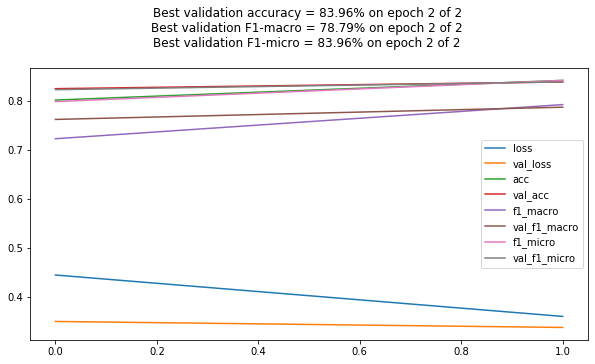

Epoch 3/20
 608/3582 [====>.........................] - ETA: 13s - loss: 0.3013 - acc: 0.8569 - f1_macro: 0.8042 - f1_micro: 0.8580

KeyboardInterrupt: 

In [27]:
## Flat Model Fit
model.fit(X_tra, y_tra, 
          epochs=20, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name)
#           , learning_rate_reduction
          ])

### Load the best Model

In [28]:
model_name

'RQ1_elmo_flat_suuuuuuuppp_model_0_Adamax_lr_0.005_loss_binary_crossentropy'

In [29]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro})

### Evaluation

In [52]:
def get_scores(model, data_, batch_size, n_tags, results_file):
    
    X, y = get_input(data_, n_tags, True)
    
    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)
    
    clsrpt = classification_report(y, y_preds)
    sfm = scikit_f1_score(y, y_preds, average='macro')

    print(clsrpt)
    print('\nScikit_F1_Macro:', sfm)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\n' + str(sfm) + '\n\n')

#### Validation Set

In [53]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

In [33]:
get_scores(best_model, valid_data, batch_size, n_tags, results_file)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       269
           1       0.79      0.79      0.79       130

   micro avg       0.86      0.86      0.86       399
   macro avg       0.84      0.84      0.84       399
weighted avg       0.86      0.86      0.86       399



#### Test

In [55]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

In [36]:
get_scores(best_model, test_data, batch_size, n_tags, results_file)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       325
           1       0.71      0.58      0.64       116

   micro avg       0.83      0.83      0.83       441
   macro avg       0.78      0.75      0.76       441
weighted avg       0.82      0.83      0.82       441



0.7601584958433688
